**Hello World Example**

_This notebook is partly based on Chapter 3 of Aurelien Geron: Hand-on Machine Learning with Scikit-learn & Tensorflow._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
NB_ID = "CNN_MNIST"

# create the directory if it does not exist
os.makedirs(os.path.join(PROJECT_ROOT_DIR, "images", NB_ID), exist_ok = True)
        
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", NB_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale and RGB images:

In [3]:
import random
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def draw_func(list_of_imgs):
  fig, axs = plt.subplots(4, 4,figsize=(28, 14))

  for ax in axs.flatten(): 
    ax.imshow(list_of_imgs[random.randint(0,len(list_of_imgs)-1)], cmap=plt.cm.gray)

  plt.show()

# Import the Keras API from Tensorflow

In [4]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras import activations
# from tensorflow.keras import backend as K

# MNIST

MNIST is the hello world example of machine learning. scikit-learn can load the data directly from https://www.openml.org

In [5]:
import math
from sklearn.datasets import fetch_openml

X,y = fetch_openml('mnist_784',version=1,cache=True,return_X_y=True)
X = X.values

# Use the notion of y=f(X)
y = y.values.astype(int)
print('Data size: {0} x {1} and label size {2}'.format(X.shape[0],X.shape[1],y.shape[0]))
print('The images are of size: {0} x {0}'.format(math.sqrt(X.shape[1])))

Data size: 70000 x 784 and label size 70000
The images are of size: 28.0 x 28.0


In [6]:
 # reshape into images and normalize
 X = X.reshape(X.shape[0],28,28)/255


In [7]:
import random
X_big = np.zeros([X.shape[0],70,70])

for i, x in enumerate(X):
  rand_x = random.randint(0,42)
  rand_y = random.randint(0,42)
  X_big[i][rand_x:rand_x+28, rand_y:rand_y+28] = x


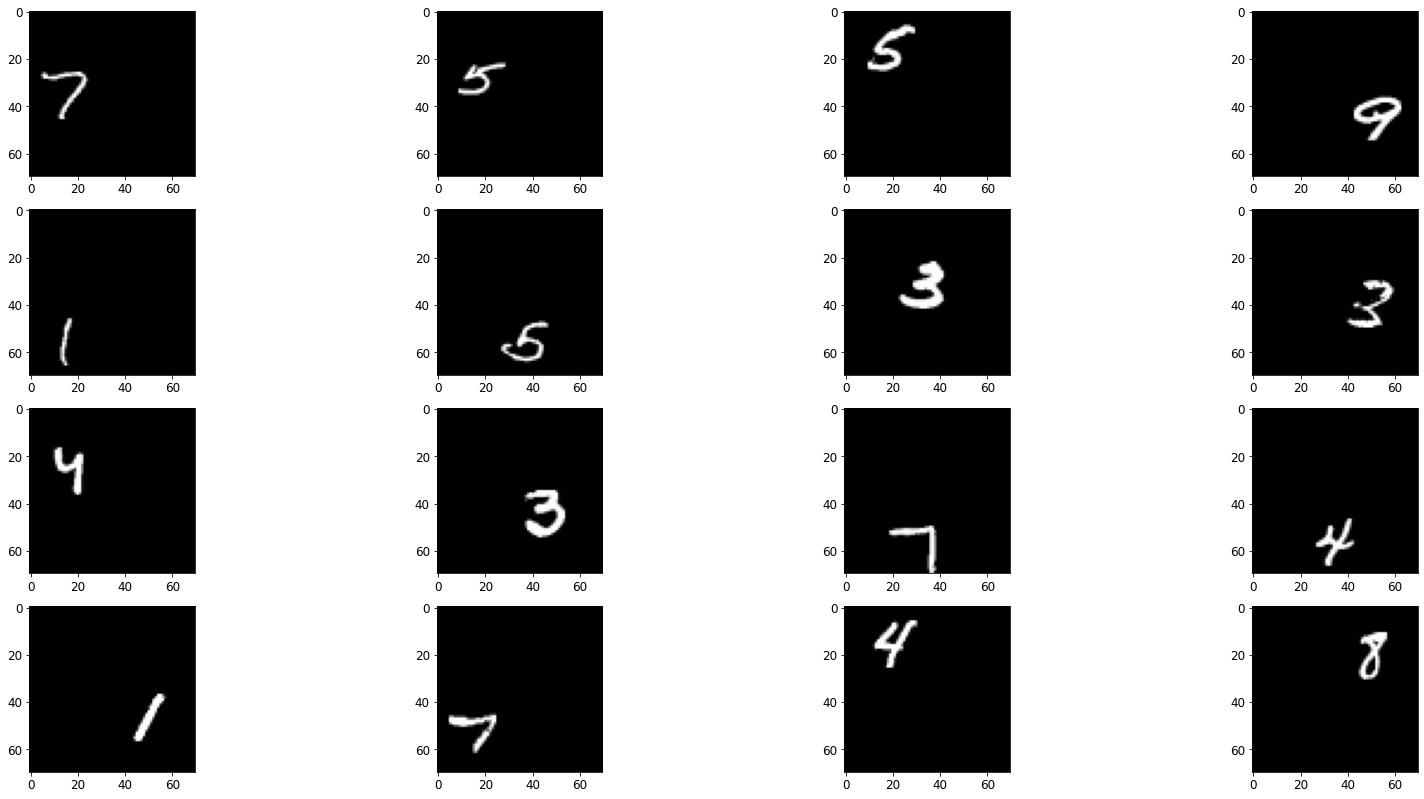

In [ ]:
draw_func(X_big)

# Test and Training Data
Let's split into training images and test images.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_big, y, test_size=1.0/7, stratify=y, random_state=42)

# shuffle_index = np.random.permutation(70000)
# reshuffle the data and use 60000 samples as training and 10000 as test
# X_train, X_test, y_train, y_test = X[shuffle_index[:60000],:], X[shuffle_index[60000:],:], y[shuffle_index[:60000]], y[shuffle_index[60000:]]



print('Matrix shape X: ', X_train.shape)
print('{0} samples for training'.format(X_train.shape[0]))
print('{0} samples for training'.format(X_test.shape[0]))

Matrix shape X:  (60000, 70, 70)
60000 samples for training
10000 samples for training


# Model

In [9]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(70,70,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10))
model.add(Activation(activations.softmax))


# model.add(Dense(1, activation='LEAKYRELU'))




adam = tensorflow.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


In [ ]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 70, 70, 6)         156       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 35, 35, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 31, 31, 16)        2416      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 3600)              0         
                                                                 
 dense_15 (Dense)            (None, 120)              

Turn the numbers into one-hot vectors

In [10]:
nClasses = 10
# Use Keras' handy utils
y_train_k = tensorflow.keras.utils.to_categorical(y_train, num_classes=nClasses)
y_test_k = tensorflow.keras.utils.to_categorical(y_test, num_classes=nClasses)


# MNIST Training

In [11]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1)

batchSize = 128
nEpochs = 50

history = model.fit(X_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                    validation_data=(X_test, y_test_k),
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/50
469/469 [==============================] - 14s 10ms/step - loss: 1.2454 - accuracy: 0.5633 - val_loss: 0.5385 - val_accuracy: 0.8353 - lr: 5.0000e-04
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.4116 - accuracy: 0.8736 - val_loss: 0.3407 - val_accuracy: 0.8940 - lr: 5.0000e-04
Epoch 3/50
469/469 [==============================] - 4s 9ms/step - loss: 0.2731 - accuracy: 0.9176 - val_loss: 0.2833 - val_accuracy: 0.9147 - lr: 5.0000e-04
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.2051 - accuracy: 0.9374 - val_loss: 0.2444 - val_accuracy: 0.9289 - lr: 5.0000e-04
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1614 - accuracy: 0.9500 - val_loss: 0.2352 - val_accuracy: 0.9299 - lr: 5.0000e-04
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1282 - accuracy: 0.9598 - val_loss: 0.2170 - val_accuracy: 0.9354 - lr: 5.0000e-04
Epoch 7/50
469/469 [========================

# Saliency

In [17]:
images = tf.convert_to_tensor(X_train[:100])
loss_instance = tf.losses.CategoricalCrossentropy()

with tf.GradientTape(persistent=True) as tape:
  tape.watch(images)
  preds = model(images)
  loss_values = loss_instance(preds,y_train_k[:100])

# dl_dx = tape.gradient(loss_values, images)
dy_dx = tape.gradient(preds, images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


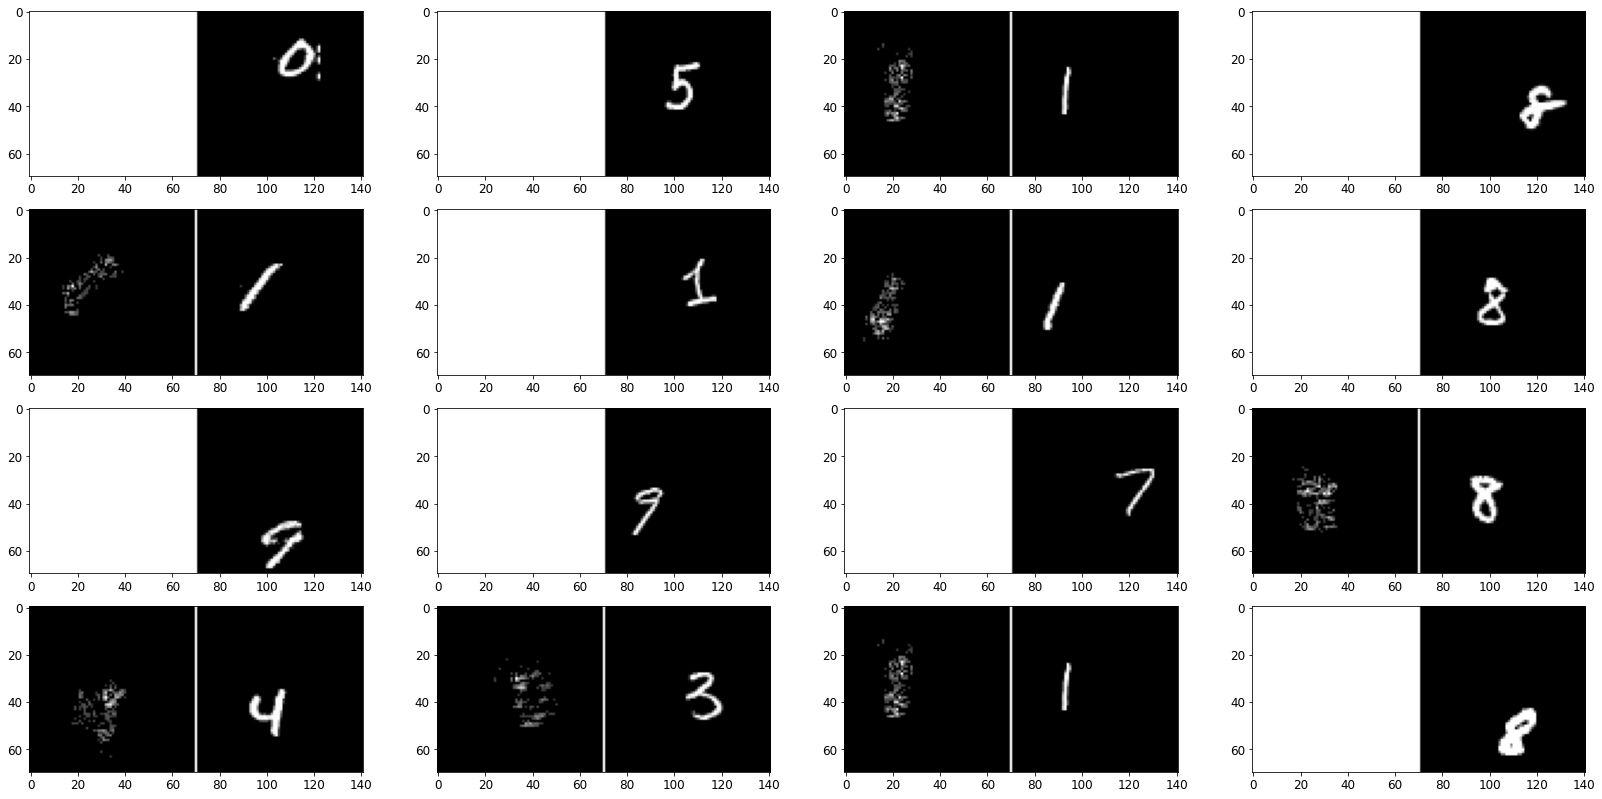

In [18]:
dl_dx_numpy = dy_dx.numpy().copy()
dl_dx_numpy = np.abs(dl_dx_numpy)

dl_dx_numpy = [(i - i.min())/(i.max()-i.min()) for i in dl_dx_numpy]
dl_dx_numpy = np.array(dl_dx_numpy)
dl_dx_numpy[dl_dx_numpy<0.2] = 0

imgs_to_show = np.concatenate([dl_dx_numpy,np.ones([100,70,1]),images], axis=2)
draw_func(imgs_to_show)

# Your turn:

*   Apply saliency using the inputs to softmax instead of loss
*   Bonus: Apply detection using Saliency maps

